# Solving the maximum margin problem with quadratic programming (QP) and the RBF kernel

The best QP solver for Python is "cvxopt."

First, let's set up synthetic data forming a well separated annulus.


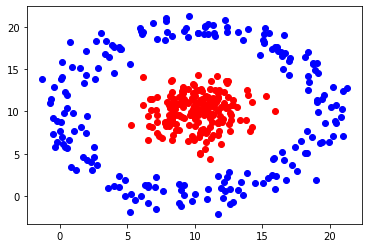

In [50]:
import numpy as np
import cvxopt
import matplotlib.pyplot as plt

# Gaussian center of the annulus

m_per_class = 200

mu = np.array([10, 10])
sigma = np.array([[3, 0], [0, 3]])
X1 = np.random.multivariate_normal(mu, sigma, m_per_class)

# Outer ring of annulus

r = 10
sigma = 1
theta = np.random.uniform(0, 2 * np.pi, m_per_class)
r = r + np.random.normal(0, sigma, m_per_class)
x, y = 10 + np.cos(theta) * r, 10 + np.sin(theta) * r
X2 = np.concatenate((x.reshape(-1, 1), y.reshape(-1, 1)), 1)

plt.plot(X1[:,0], X1[:,1], 'ro')
plt.plot(X2[:,0], X2[:,1], 'bo')
plt.show()


In [51]:
# Combine the classes and set targets

X = np.concatenate((X1, X2), 0)
y = np.concatenate((-np.ones((m_per_class, 1)), np.ones((m_per_class, 1))), 0)
m = X.shape[0]
n = 2

def cvxopt_solve_qp(Q, c, A=None, b=None, E=None, d=None):
    Q = .5 * (Q + Q.T)  # make sure Q is symmetric
    args = [cvxopt.matrix(Q), cvxopt.matrix(c)]
    if A is not None:
        args.extend([cvxopt.matrix(A), cvxopt.matrix(b)])
        if E is not None:
            args.extend([cvxopt.matrix(E), cvxopt.matrix(d)])
    sol = cvxopt.solvers.qp(*args)
    if 'optimal' not in sol['status']:
        return None
    return np.array(sol['x']).reshape((Q.shape[1],))


In [52]:

# Kernels

def linear_kernel(X):
    return X @ X.T


def rbf_kernel(X, sigma):
    m = X.shape[0]
    K = np.zeros((m, m))
    for i in range(m):
        for j in range(m):
            K[i, j] = (X[i,:] - X[j,:]) @ (X[i,:] - X[j,:])
    K = np.exp(- K / 2 / sigma / sigma)
    return K
        
            
# QP problem: set Q, c, A, b

# Parameters are alpha's

# max_alpha [sum of alphas] - 1/2 sum_i,j alpha_i alpha_j y^i y^j <x^i,x^j>
# alpha_i >= 0
# sum alpha_i * y^i = 0

m = X.shape[0]
rbf_sigma = 2
c = - np.ones((m, 1))
# Q = (y @ y.T) * linear_kernel(X, rbf_sigma)
Q = (y @ y.T) * rbf_kernel(X, rbf_sigma)
A = - np.eye(m)
b = np.zeros((m, 1))
E = y.T
d = np.zeros((1, 1))

opt_params = cvxopt_solve_qp(Q, c, A, b, E, d)


     pcost       dcost       gap    pres   dres
 0: -6.5389e+00 -4.5599e+02  2e+03  1e+00  8e-16
 1:  1.6971e-01 -1.6038e+02  2e+02  3e-03  6e-16
 2: -8.7080e+00 -3.6458e+01  3e+01  5e-04  6e-16
 3: -1.0716e+01 -1.7983e+01  7e+00  8e-05  4e-16
 4: -1.1583e+01 -1.3321e+01  2e+00  6e-06  3e-16
 5: -1.1863e+01 -1.2406e+01  5e-01  1e-06  3e-16
 6: -1.1981e+01 -1.2102e+01  1e-01  3e-08  3e-16
 7: -1.2011e+01 -1.2035e+01  2e-02  6e-09  3e-16
 8: -1.2014e+01 -1.2030e+01  2e-02  2e-09  3e-16
 9: -1.2018e+01 -1.2023e+01  5e-03  7e-10  3e-16
10: -1.2019e+01 -1.2021e+01  2e-03  6e-11  3e-16
11: -1.2020e+01 -1.2020e+01  2e-04  6e-12  3e-16
12: -1.2020e+01 -1.2020e+01  2e-05  3e-13  3e-16
13: -1.2020e+01 -1.2020e+01  4e-07  6e-15  3e-16
Optimal solution found.


In [46]:
print('Alphas that are not zero:', opt_params[opt_params > 1e-5])
print('Corresponding labels:', y[opt_params > 1e-5])
opt_params[opt_params > 1e-5] @ y[opt_params > 1e-5]

Alphas that are not zero: [9.99998269e-01 9.99977049e-01 9.99999845e-01 9.99999140e-01
 9.99999935e-01 9.99999578e-01 9.99999879e-01 9.99999722e-01
 9.77995873e-02 9.99999949e-01 9.99999547e-01 9.99999924e-01
 9.99999948e-01 5.09592950e-01 7.99669785e-01 9.99999948e-01
 9.99999815e-01 2.26231155e-05 9.99999878e-01 9.99999899e-01
 9.99999934e-01 9.99999935e-01 9.99999655e-01 6.17362526e-02
 9.99999663e-01 2.71433423e-05 1.71488871e-05 9.99999450e-01
 9.99999901e-01 5.16769352e-05 7.69507793e-01 9.99999946e-01
 9.99999948e-01 9.99999943e-01 9.99999602e-01 1.97006091e-05
 9.99995590e-01 9.99999814e-01 9.99999911e-01 9.99999182e-01
 9.99999445e-01 9.99997661e-01 9.99999867e-01 1.61077601e-01
 9.53166955e-01 9.99999927e-01 9.99999891e-01 4.76141982e-01
 9.99999944e-01 9.99999945e-01 9.99990169e-01 3.17535287e-01
 9.99999936e-01 3.63678379e-01 9.99999898e-01 3.28870103e-01
 9.99997412e-01 6.15806819e-01 9.99995299e-01 9.99999528e-01
 9.99999863e-01 3.08604310e-01 9.99996036e-01 9.99999636e-0

array([0.00013465])

In [47]:
# How to perform inference with a kernel rather than w,b?

def b_from_alpha(X, y, alpha, rbf_sigma):
    S = np.where(alpha > 1e-5)[0]
    alpha_s = alpha[S].reshape(-1,1)
    y_s = y[S]
    X_s = X[S,:]
    b = (y_s - ((alpha_s * y_s).T * rbf_kernel(X_s, rbf_sigma)).sum(axis=1, keepdims=True)).mean()
    return b

def rbf_kernel_1(x, xprime, rbf_sigma):
    return np.exp(- (x - xprime) @ (x - xprime) / 2 / rbf_sigma / rbf_sigma)
    
def svm_predict(x, X, y, alpha, rbf_sigma):
    b = b_from_alpha(X, y, alpha, rbf_sigma)
    results = np.zeros((x.shape[0], 1))
    for i in range(x.shape[0]):
        results[i] = 0
        for j in range(X.shape[0]):
            results[i, 0] += alpha[j] * y[j, 0] * rbf_kernel_1(x[i,:], X[j,:], rbf_sigma)
        results[i] += b
    return np.sign(results)

# svm_predict(np.array([[10, 10], [20, 20]]), X, y, opt_params, rbf_sigma)

In [48]:
train_pred = svm_predict(X, X, y, opt_params, rbf_sigma)
accuracy = (train_pred == y).mean()
print('Training accuracy:', accuracy)

Training accuracy: 0.8825


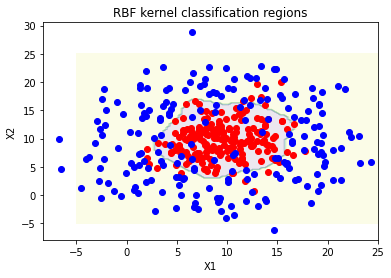

In [49]:

# Blue margin line

# x21 = (-w[0] * x11 - b + 1) / w[1]
# x22 = (-w[0] * x12 - b + 1) / w[1]

# plt.plot((x11, x12), (x21, x22), 'k-')

# Red margin line

# x21 = (-w[0] * x11 - b - 1) / w[1]
# x22 = (-w[0] * x12 - b - 1) / w[1]

# plt.plot((x11, x12), (x21, x22), 'k-')

plt.plot(X1[:,0], X1[:,1], 'ro')
plt.plot(X2[:,0], X2[:,1], 'bo')

# Overlay colored regions according to svm_predict

grid_x, grid_y = np.mgrid[-5:25:100j, -5:25:100j]
grid_xy = np.vstack([grid_x.ravel(), grid_y.ravel()]).T
grid_z = svm_predict(grid_xy, X, y, opt_params, rbf_sigma).reshape((100, 100))

plt.contourf(grid_x, grid_y, grid_z, alpha=0.1)

plt.title('RBF kernel classification regions')
plt.xlabel('X1')
plt.ylabel('X2')

plt.show()